In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 1000
innov_dim = 250

In [6]:
bounds = {'pi': {'max': 0, 'min':-16, 'dim':17}, 'phi': {'max': -.25, 'min':-.4, 'dim':5}, 
          'theta': {'max':10, 'min': 0, 'dim':17}}

In [7]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [8]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                  pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [9]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [10]:
data.vol.describe()

count    2000.000000
mean        0.013652
std         0.016952
min         0.000010
25%         0.002253
50%         0.007935
75%         0.018220
max         0.138384
Name: vol, dtype: float64

In [11]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [12]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [15]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [16]:
data.corr()

,vol,rtn
vol,1.0000,0.0633
rtn,0.0633,1.0000


In [17]:
data.head()

,vol,rtn
2000-01-01,0.024697,-0.117313
2000-01-02,0.009232,0.272910
2000-01-03,0.010345,0.082323
2000-01-04,0.028500,0.069972
2000-01-05,0.021133,-0.078619


In [18]:
data.vol.var()

0.00028737984658565096

In [19]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.849441802266965,
  'log_scale': -5.4437828063252205,
  'logit_rho': 1.3156829331682527},
            log_both  log_scale  logit_rho
 log_both   0.005952   0.000980  -0.007089
 log_scale  0.000980   0.002162  -0.000250
 logit_rho -0.007089  -0.000250   0.018071)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
omega

{'gamma': 0.01157115863894426,
 'beta': 4.228460853664619,
 'psi': -3.2466506655023504,
 'zeta': 0.8636787204655134,
 'log_both': -5.849441802266965,
 'log_scale': -5.4437828063252205,
 'logit_rho': 1.3156829331682527}

In [22]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.018908,-4.212305e-05,0.000000,0.000000,0.000000,-0.015838,0.000000
gamma,-0.000042,2.981976e-07,0.000000,0.000000,0.000000,0.000020,0.000000
log_both,0.000000,0.000000e+00,0.005952,0.000980,-0.007089,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000980,0.002162,-0.000250,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.007089,-0.000250,0.018071,0.000000,0.000000
psi,-0.015838,2.030923e-05,0.000000,0.000000,0.000000,0.046072,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000758


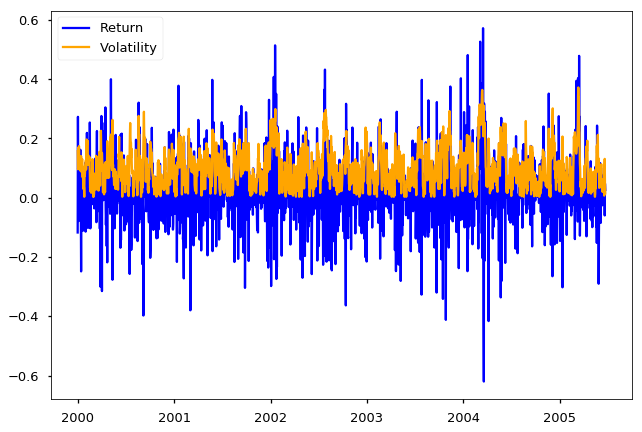

In [23]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [24]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.004065,0.000355
rtn,0.000355,0.011989


In [25]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

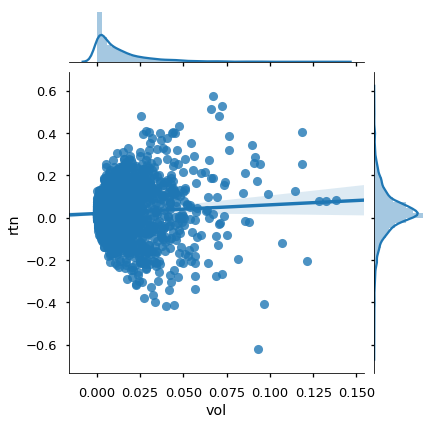

In [26]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [27]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013652,0.024950
std,0.016952,0.109492
min,0.000010,-0.620123
25%,0.002253,-0.025010
50%,0.007935,0.021703
75%,0.018220,0.072114
max,0.138384,0.571960


## I now estimate all of the parameters

In [28]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [29]:
vl.compute_init_constants(data.vol)

{'log_both': -5.902515806764626,
 'log_scale': -5.465559839402719,
 'logit_rho': 1.3803271514796243}

In [30]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [31]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [32]:
vl.compute_init_constants(data.vol)

{'log_both': -5.902515806764626,
 'log_scale': -5.465559839402719,
 'logit_rho': 1.3803271514796243}

In [33]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.839847484046236,
  'log_scale': -5.464161937928357,
  'logit_rho': 1.3968653347114879},
            log_both  log_scale  logit_rho
 log_both   0.005528   0.000864  -0.006135
 log_scale  0.000864   0.002498   0.000071
 logit_rho -0.006135   0.000071   0.016633)

In [34]:
# with Pool(8) as pool:
#     est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
#                                       total=len(data_arr)))

In [35]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [36]:
# ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
#             for est in est_arr]

In [37]:
# vol_fig, vol_ax = mpl.pyplot.subplots()
# sns.distplot(ar_stats, ax=vol_ax)
# vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
# vol_ax.set_xlim([0,20])
# vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
# vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [38]:
# 100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

In [39]:
qlr_draws = vl.qlr_sim([-.4, -10, 1.768], omega, omega_cov, bounds=bounds, innov_dim=1000)

In [40]:
# t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
#             for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
# t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [41]:
# true_params['log_both']

In [42]:
# np.amin([est[0]['log_both'] for est in est_arr])

In [43]:
# t_stats_df.describe()

In [44]:
# for name, col in t_stats_df.items():
#     fig, ax = mpl.pyplot.subplots()
#     sns.distplot(col, ax=ax)
#     ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
#     ax.set_xlim([-4,4])

In [45]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [46]:
estimator(data_arr[0])

({'gamma': 0.012537242363042652,
  'beta': 4.2498330975249,
  'psi': -3.406568825271777,
  'zeta': 0.8401636283444139,
  'log_both': -5.839847484046236,
  'log_scale': -5.464161937928357,
  'logit_rho': 1.3968653347114879,
  'phi': -0.39353698500202833,
  'pi': -16.0,
  'theta': 1.6194550965948267},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.014696 -3.807192e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000038  3.368255e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.005528   0.000864  -0.006135       NaN   
 log_scale  0.000000  0.000000e+00  0.000864   0.002498   0.000071       NaN   
 logit_rho  0.000000  0.000000e+00 -0.006135   0.000071   0.016633       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.001120   
 pi              NaN           NaN       NaN        NaN        NaN -0.368761   
 psi       -0.012100  1.504112e-05  0.000000   0.000000   0

In [47]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [48]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [49]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

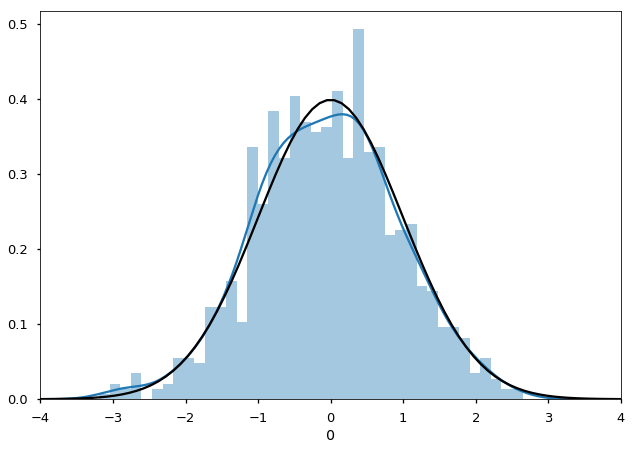

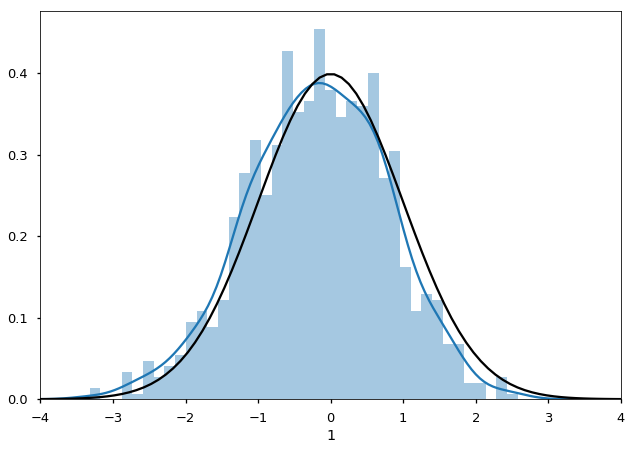

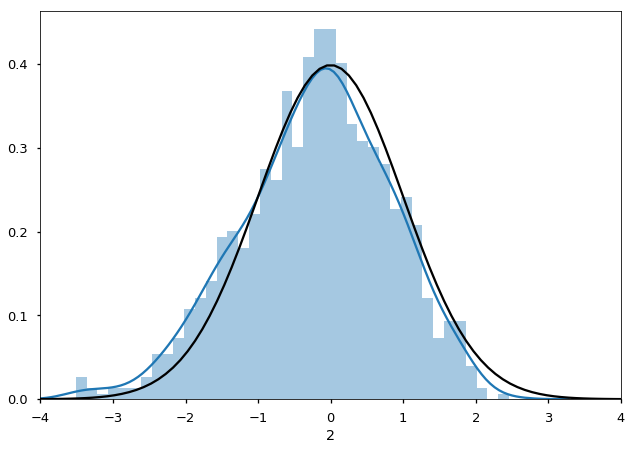

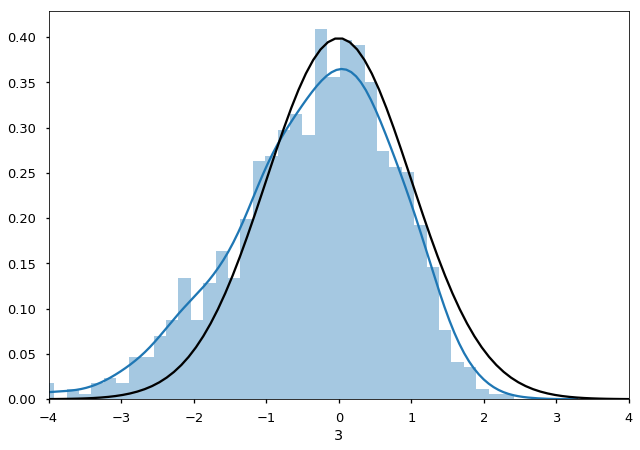

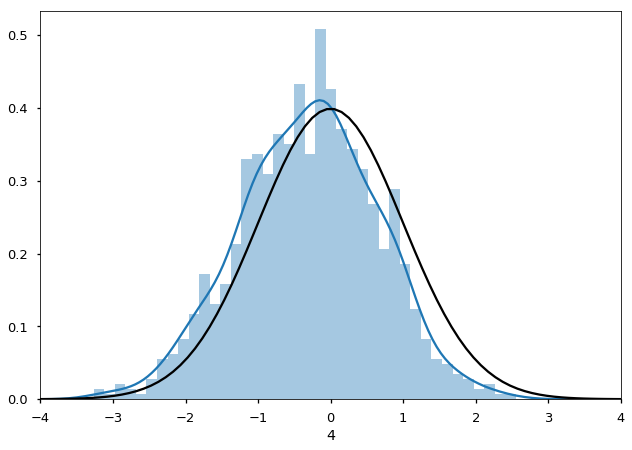

In [50]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [51]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

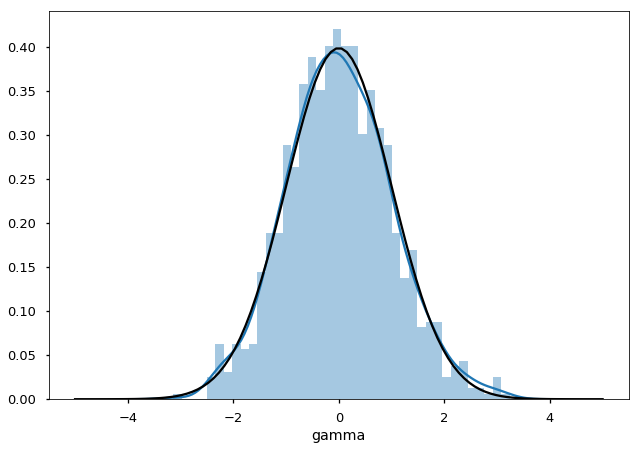

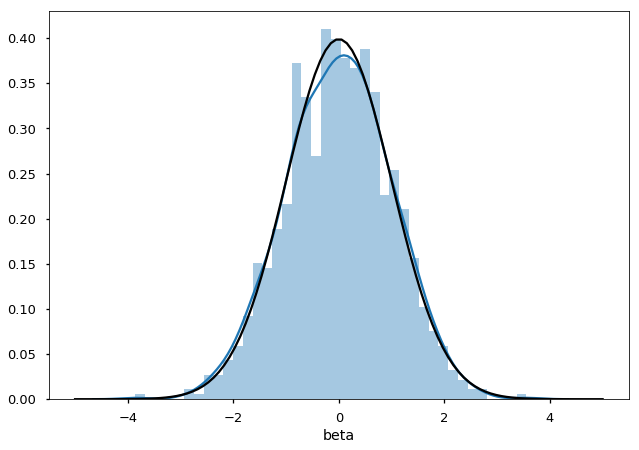

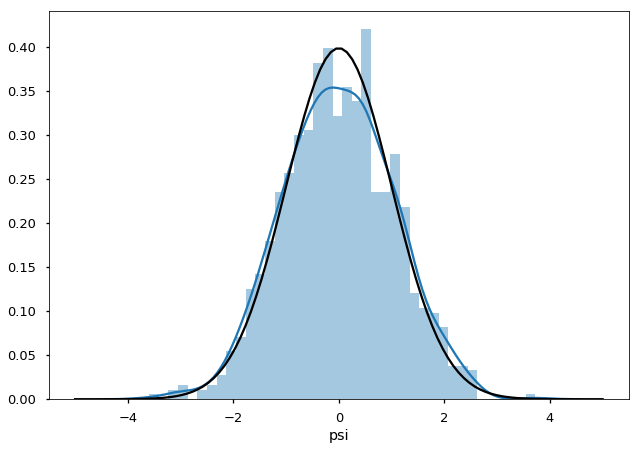

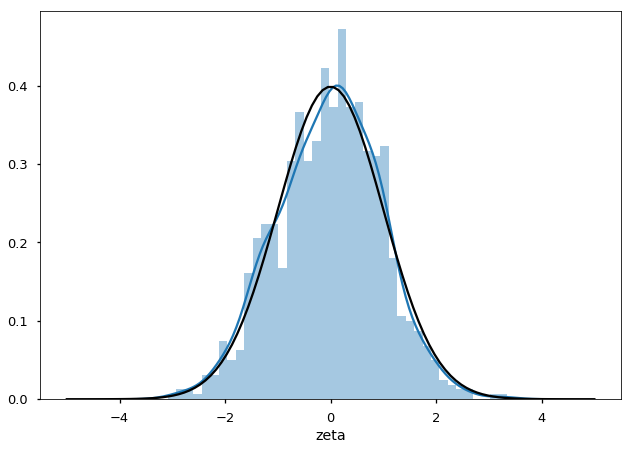

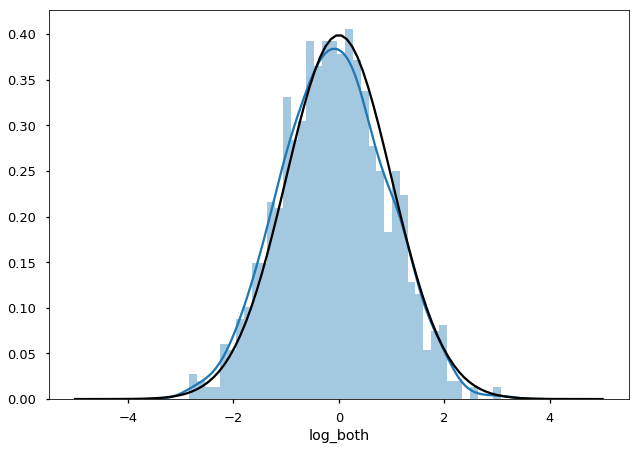

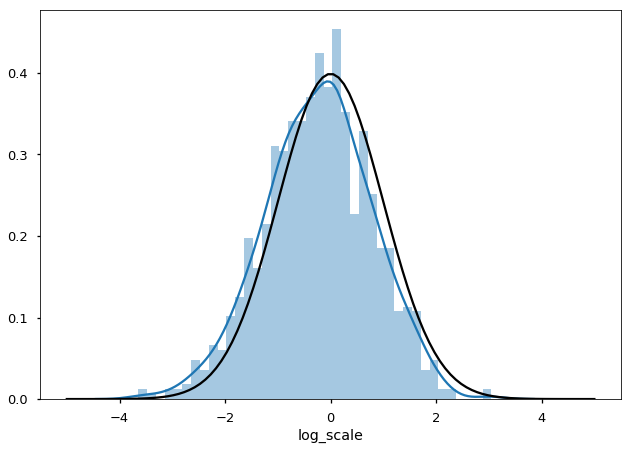

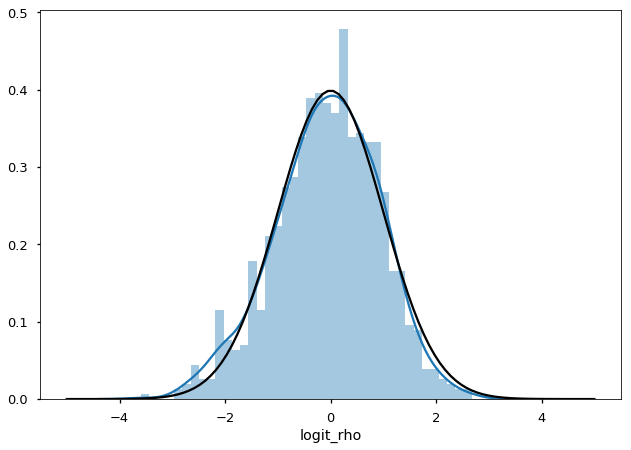

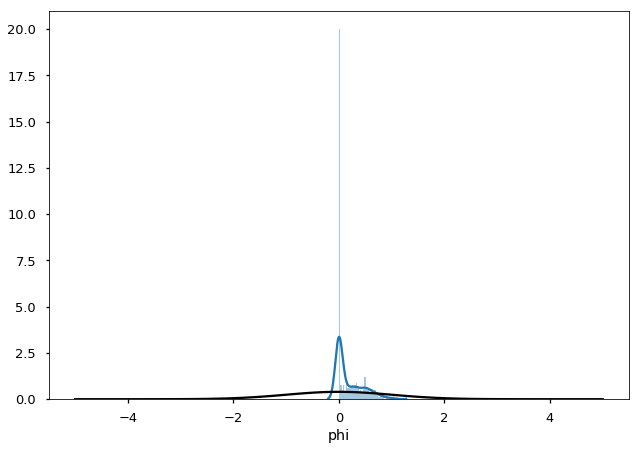

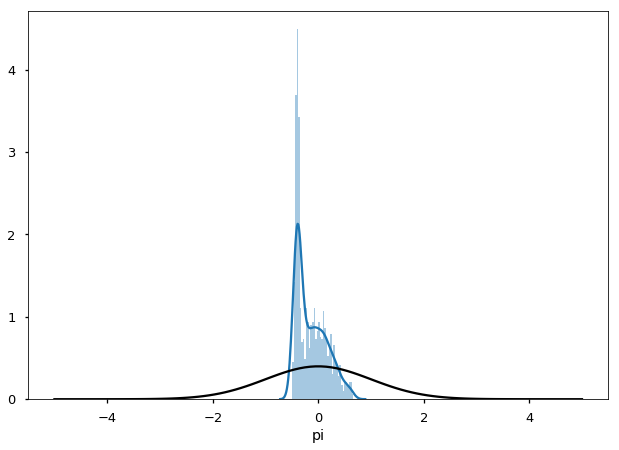

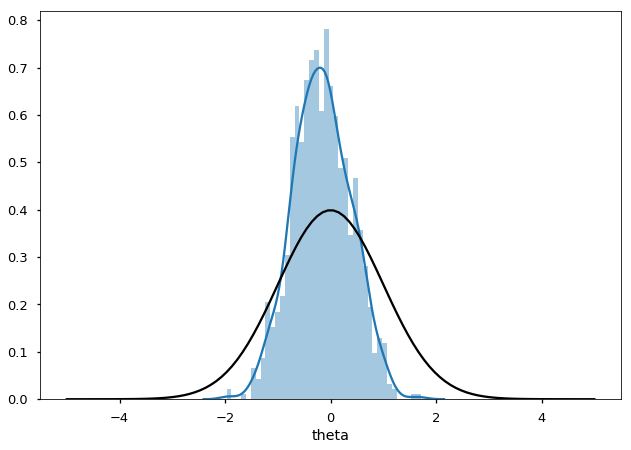

In [52]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [53]:
est = est_arr[0]

In [54]:
names = ['beta', 'gamma', 'log_both', 'logit_rho', 'psi', 'zeta']

In [55]:
est[1].loc[names, names]

,beta,gamma,log_both,logit_rho,psi,zeta
beta,0.013797,-4.007842e-05,0.000000,0.000000,-0.010736,0.000000
gamma,-0.000040,3.618474e-07,0.000000,0.000000,0.000012,0.000000
log_both,0.000000,0.000000e+00,0.005401,-0.005228,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.005228,0.013578,0.000000,0.000000
psi,-0.010736,1.240550e-05,0.000000,0.000000,0.044145,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000823


In [56]:
qlr_reduced_form = [((pd.Series(est[0]).loc[names] - pd.Series(total_true_params).loc[names]) 
    @ np.linalg.inv(est[1].loc[names, names]) 
    @  (pd.Series(est[0]).loc[names] - pd.Series(total_true_params).loc[names]) )
                    for est in tqdm.tqdm_notebook(est_arr)] 

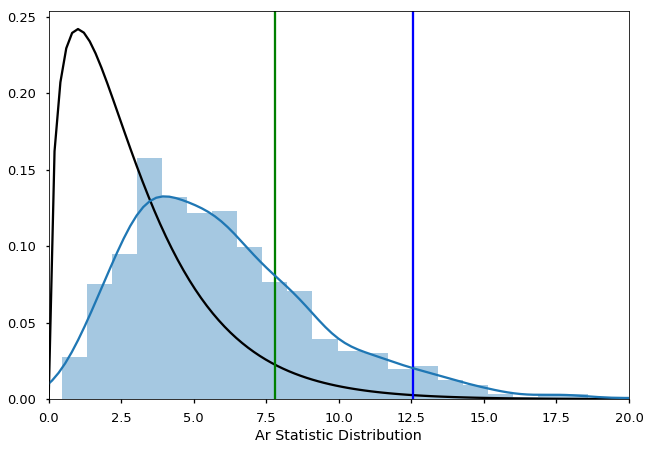

In [82]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=len(names)), color='black')

    ax.set_xlabel('AR-Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(qlr_reduced_form, q=95), color='blue')
    ax.axvline(stats.chi2.ppf(df=len(names), q=.95), color='green')
    sns.distplot(qlr_reduced_form, ax=ax)

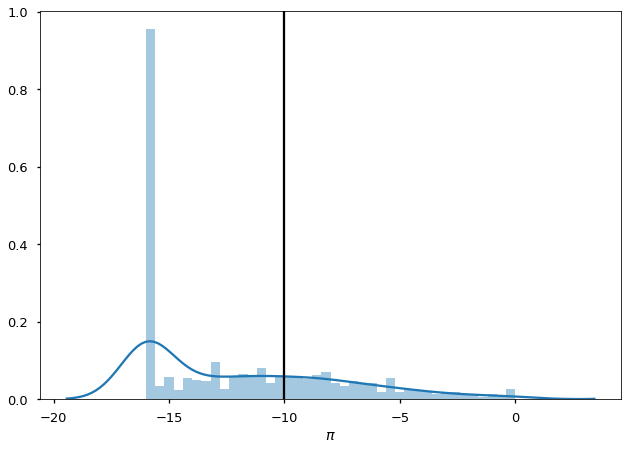

In [58]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [59]:
omega

{'gamma': 0.01157115863894426,
 'beta': 4.228460853664619,
 'psi': -3.2466506655023504,
 'zeta': 0.8636787204655134,
 'log_both': -5.849441802266965,
 'log_scale': -5.4437828063252205,
 'logit_rho': 1.3156829331682527}

In [60]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [61]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [62]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [63]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [64]:
compute_ar(est_arr[0])

6.569460217441964

In [65]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [66]:
ar_results.head()

,0
0,1.720757
1,6.569460
2,2.645975
3,14.415994
4,4.841457


In [67]:
omega

{'gamma': 0.012342517656499883,
 'beta': 4.0861558719474145,
 'psi': -3.3422566205923188,
 'zeta': 0.8960779604615686,
 'log_both': -5.927149543318788,
 'log_scale': -5.57561520170625,
 'logit_rho': 1.3231009266070466}

In [68]:
true_prices

[-0.4, -10, 1.768]

In [71]:
vl._qlr_in([-.4, -10, 1.768], omega, omega_cov)

6.569460217441964

In [72]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [73]:
 stats.chi2.ppf(df=4, q=.95)

9.487729036781154

In [74]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

0    11.4
dtype: float64

In [75]:
# results[results <=0] = 0 

In [76]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [77]:
np.percentile(qlr_draws, 95)

0.0

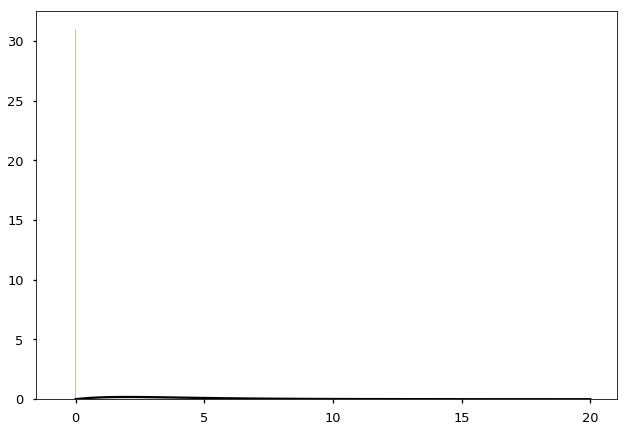

In [88]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
#     sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')
    sns.distplot(qlr_draws, ax=ax)
#     sns.distplot(returnval.qlr_stat, color='orange')
#     ax.set_xlabel('AR Statistic Distribution')
#     ax.set_xlim(0, 20)
#     ax.axvline(np.percentile(returnval.qlr_stat, q=95), color='orange')
#     ax.axvline(np.percentile(qlr_draws, q=95), color='blue')

#     ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    

In [79]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [80]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [81]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=10, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [83]:
returnval.median()

qlr_stat               1.884573
robust_qlr_qauntile    0.000000
robust                 1.000000
standard               0.000000
dtype: float64

In [84]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,0.186238,0.0,True,False
1,13.704756,0.0,True,True
2,1.771174,0.0,True,False
3,0.219845,0.0,True,False
4,0.166303,0.0,True,False


In [85]:
returnval.mean()

qlr_stat               3.077831
robust_qlr_qauntile    0.000000
robust                 1.000000
standard               0.092000
dtype: float64

In [ ]:
np.percentile(returnval.qlr_stat, 95)

In [ ]:
returnval.head(100)

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)